In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, copy
import time
from scipy.interpolate import make_interp_spline

In [17]:
# Matrices d'adjacence
# Serviront pour les tests

M = np.array([[0,1,1,0,0,0],
              [1,0,0,1,1,0],
              [1,0,0,1,0,0],
              [0,1,1,0,1,0],
              [0,1,0,1,0,1],
              [0,0,0,0,1,0]])

M2 = np.array([[0,1,1,1,0,0,0,0],
               [1,0,1,1,1,0,0,0],
               [1,1,0,1,1,0,0,0],
               [1,1,1,0,0,0,0,0],
               [0,1,1,0,0,1,1,1],
               [0,0,0,0,1,0,1,1],
               [0,0,0,0,1,1,0,1],
               [0,0,0,0,1,1,1,0]])

### 1.a

- Le multi graphe G est représenté par une matrice d'adjacence.
- Pour réaliser l'opération de contraction d'une arête (i,j), on réalise les traitements suivants
sur la matrice d'adjacence représentant le graphe G:<br>
    - Ajouter à la ligne et colonne du sommet i, la ligne et colonne du sommmet j. <br>
    - Supprimer la ligne et la colonne correspondants au sommet j (car a été fusionné avec le sommet i pour construire un nouvel ensemble (La suppresion se fait en remplaçant la ligne et la colonne par -1).

In [18]:
def contract(A,i,j):
    """
    Realise the contraction in the graph M represented by its adjancency matrix
    """
    li = A[i,:]
    lj = A[j,:]
    ci = A[:,i]
    cj = A[:,j]

    A[i,:] = li + lj
    A[:,i] = ci + cj

    A[i,i] = 0

    A[j,:] = -1
    A[:,j] = -1
    
    return A

### Complexité :
L'opération de contraction présentée ci-dessus se fait en temps constant O(n).

En effet, il s'agit juste de remplacer deux lignes et deux colonnes connus de la matrice d'adjacence M par des valeurs, donc il suffit de parcourir toute la ligne/colonne et d'assigner les nouvelles valeurs, ce qui se fait en temps O(n).

### 1.b

Module de création de graphe (par génération de matrices d'adjacences), servira pour la partie experimentale et analyse de la complexité.

In [53]:
def create_graph(n_vertex,ty = "random"):
    shape = (n_vertex,n_vertex)
    if ty=="random":
        # how to create a random graph
        # add an edge with probability p
        p = [0.2,0.8] # To be verified
        M = np.zeros(shape)
        for i in range(n_vertex):
            for j in range(n_vertex):
                e = np.random.choice([0,1],1,[p])
                M[i,j] = e
                M[j,i] = e
        np.fill_diagonal(M,0)
    elif ty=="complete":
        M = np.ones(shape)
        np.fill_diagonal(M,0)
    elif ty=="biparti":
        n = n_vertex//2
        A = np.concatenate((np.zeros((n,n)), np.ones((n,n))), axis=0)
        B = np.concatenate((np.ones((n,n)), np.zeros((n,n))), axis=0)
        M = np.concatenate((A,B), axis=1)
        
    elif ty=="cyclique":
        M = np.zeros(shape)
        for i in range(n_vertex-1):
            M[i,i+1] = 1
        M[0,n_vertex-1] = 1
        for i in range(n_vertex):
            for j in range(n_vertex):
                M[j,i] = M[i,j]
    
    else:
        print('enter a valid graph type')
        return
    
    return M.astype(int)

In [54]:
G = create_graph(8,ty="random")
G

array([[0, 1, 0, 0, 1, 1, 1, 1],
       [1, 0, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 0]])

In [29]:
G_random = create_graph(8,ty="random")
G_random

array([[0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 1],
       [1, 1, 0, 1, 0, 0, 1, 0]])

In [30]:
G_complete = create_graph(8,ty="complete")
G_complete

array([[0, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 0]])

In [31]:
G_biparti = create_graph(8,ty="biparti")
G_biparti

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0]])

In [32]:
G_cyclique = create_graph(8,ty="cyclique")
G_cyclique

array([[0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0]])

### 1.c

le graphe G est possiblement devenu un multi-graphe avec plusieurs arêtes entre deux sommets.
Dans notre analyse théorique de la complexité de l'algorithme de Karger, nous avons supposée
que l'arêtes e de l'opération de sélection aléeatoire dans la boucle tant que est
tirée uniformement aléatoirement parmi toutes les arêtes possibles. 

Pour effectuer ce tirage aléatoire lorsque le multi-graphe G est représenté par une matrice d'adjacence, on réalise les étapes suivantes :

Etant donnée une liste somme_ligne de tailles nombre de sommets dans le graphe G, et contenant dans chaque case le nombre de sommmets par ligne dans la matrice d'adjacence :

Exemple :

Pour la matrice  $\begin{bmatrix}
0 & 1 & 1\\ 
1 & 0 & 1\\ 
1 & 0 & 0
\end{bmatrix}$ on retrouve la liste : $\begin{bmatrix}
2 & 2 & 1
\end{bmatrix}$

Donc, pour choisir aléatoirement selon une loi uniforme une arête parmi toutes les arêtes du graphe, on tire un nombre aléatoire entre 1 et le nombre d'arêtes du graphe G (qui n'est rien d'autre que la somme des éléments de la liste sommme_liste).

Soit a le numéro de l'arête qu'on a tiré précédemment, en utilisant la somme cummulée des éléments de la liste somme_ligne, on peut reperer la ligne ou se trouve cette arête. Cette étape se réalise en temps linéaire O(n) dans le pire des cas.

De même pour la colonne, on fait la somme cummulé et on retrouve le numéro de colonne. Cette étape se réalise également en temps linéaire O(n) dans le pire des cas.

A la fin de cette procédure, on retourne une l'indice de l'arête (i,j) tiré aléatoirement du graphe G en temps linéaire.


In [24]:
# Implémentation de la fonction de tirage aléatoire d'arête
# Random choice
def arrete_choice(M, sum_lines) :
    """
    Chooses a random edge from the multi graph G
    represented by its adjacency matrix
        M : Adjacency matrix
        somme_ligne : list containing number of edges per line in M
    returns :
        M[i,j],i,j
    """
    # Pick up up a random number of edge
    nb_arrete = np.sum(sum_lines)
    random_arrete = np.random.randint(nb_arrete)
    
    # Find in linear time the line index of that edge
    cumul = 0
    for i in range(len(sum_lines)) :
        cumul += sum_lines[i]
        if cumul > random_arrete :
            break
    
    # Find in linear time the column index of that edge
    j = random_arrete - (cumul - sum_lines[i])
    cumul = 0
    for k in range(M.shape[1]) :
        cumul += M[i,k] if M[i,k]>0 else 0
        if cumul > j :
            break

    return M[i,k],i,k

### 1.d

In [55]:
def Karger(M, verbose= False, len_cut = True) :
    # Show the resulting list
    def print_fusion(fusion):
        for i in range(len(fusion)):
            if len(fusion[i])>0:
                print(fusion[i])
    
    # Init
    A = M.copy()
    fusion = [[i] for i in range(A.shape[0])]
    
    
    sum_lines = np.sum(A,axis=1)
    nb_vertex = A.shape[0]
    
    if verbose: 
        print("---")
        print("DEBUG")
        print("---")
        print(A)
        print(sum_lines)
    # While the number of vertex is higher than 2
    while nb_vertex > 2 :
        # An inner loop to avoid choosing an edge that has
        # a negative value in the adjacency matrix
        # This is taking a lot of time when the matrix is high dimensional
        while True : 
            val,i,j = arrete_choice(A, sum_lines)
            # print(val, i,j)
            if val>0:
                break
        # realises a contraction on the edge (i,j)
        A = contract(A,i,j)
        
        ## Update of the data structures
        
        # Append the merged vertex
        for e in fusion[j]:
            fusion[i].append(e)
        fusion[j] = []
        
        # Update the sum_lines list
        #sum_lines[i] += sum_lines[j] - val
        sum_lines[i] += sum_lines[j]
        sum_lines[i] -= 2*val
        sum_lines[j] = 0
        # We have merged two vertex
        nb_vertex-=1
        # Log
        if verbose:
            print(i,j)
            print(A)
            print("sommets: ",nb_vertex)
            print("somme ligne :", sum_lines)
            
    if verbose :
        print_fusion(fusion)
    
    S = []
    for i in range(len(fusion)):
        if len(fusion[i])>0:
            S.append(fusion[i])
    
    coupure = A[A>0][0]

    
    if len_cut:
        return S[0], coupure
    return S[0]


In [56]:
S, cut = Karger(M)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [0, 2]
The cut returned by Karger Algorithm : 2


In [57]:
S, cut = Karger(G_complete)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [1, 7, 6, 0, 5, 2, 3]
The cut returned by Karger Algorithm : 7


In [62]:
S, cut = Karger(G_biparti)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [5]
The cut returned by Karger Algorithm : 4


In [59]:
S, cut = Karger(G)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [2, 3]
The cut returned by Karger Algorithm : 4


In [60]:
S, cut = Karger(G_cyclique)
print("S1 :", S)
print("The cut returned by Karger Algorithm :", cut)

S1 : [3, 2, 0, 7, 1]
The cut returned by Karger Algorithm : 2


### Complexité:
La complexité théorique de l'algorithme de Karger vue en cours est de l'ordre de O(n²) pour une représentation par matrice d'adjacence.

---

### Analyse de la complexité de l'algorithme de Karger implémenté en utilisant une représentation par matrice d'adjacence

#### Schéma expérimental:
- Génération aléatoire d'exemple de taille différente
- Exécution de l'algorithme de Karger sur les instances générés
- Evaluation du temps d'exécution obtenu

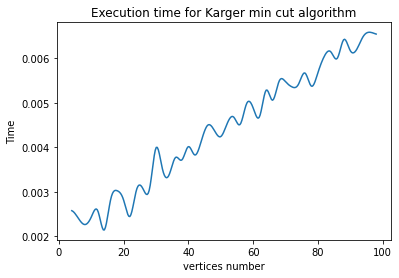

In [86]:
# Cas de graphe complet à n sommets

exec_times = []
for n in range(4, 100, 2):
    t = 0
    for it in range(100):
        G = create_graph(n, ty="complete")
        tic = time.time()
        _,_ = Karger(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x = np.arange(4,100,2)
y = exec_times

X_Y_Spline = make_interp_spline(x, y, k=3)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 300)
Y_ = X_Y_Spline(X_)

plt.plot(X_, Y_)

#plt.plot(np.log(abc), np.log(exec_times), "g")

# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

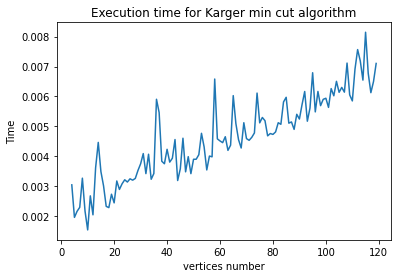

In [95]:
# Cas de graphe complet à n sommets

exec_times = []
for n in range(4, 120, 1):
    t = 0
    for it in range(100):
        G = create_graph(n, ty="complete")
        tic = time.time()
        _,_ = Karger(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plot the execution time
x = np.arange(4,120,1)
y = exec_times

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#plt.plot(x, smooth(y,19), 'g-', lw=2)
plt.plot(x,y)
# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

In [ ]:
exec_times = []
for n in range(5, 105, 5):
    t = 0
    for it in range(100):
        G = create_graph(n, ty="biparti")
        tic = time.time()
        _,_ = Karger(G)
        tac = time.time()
        t+= (tac-tic)
    exec_times.append(t/n)

# Plotting the execution time
abc = np.arange(5,105,5)
plt.plot(abc,exec_times, "r")

# Add titles and labels
plt.title('Execution time for Karger min cut algorithm')
plt.xlabel('vertices number')
plt.ylabel('Time')

# Show the figure
plt.show()

### 1.e

La deuxième structure de données pour laquelle nous avons opté est la représentation par liste d'adjacence.

In [15]:
"""
G = {1:[2,3],
    2:[1,3,4],
    3:[1,2,4],
    4:[2,3]}
"""

'\nG = {1:[2,3],\n    2:[1,3,4],\n    3:[1,2,4],\n    4:[2,3]}\n'

In [16]:
#input can be any adjacency list in a text file
data = open("testCase.txt", "r")
G = {}
for line in data:
    lst = [int(s) for s in line.split()]  # creates a list for each line of text file
    G[lst[0]] = lst[1:]  # adds the list for one vertex to the entire adj list in G
    # The code that creates an adjacency list from a text file(lines 6-10) were done with help from online resources
    
def choose_random_key(G):
    a = random.choice(list(G.keys()))  # picks a random vertex
    b = random.choice(list(G[a]))      # picks a random edge in the adjacency list
    return a, b

def contract_2(G,a,b):
    # Contraction in the case of list of adjacency representation
    G[a].extend(G[b])  # copies all items Linear time
    
    for x in G[b]:
        G[x].remove(b)  # remove the other occurrences of b in adjacency list
        G[x].append(a)  # tell them to look at a instead

    while a in G[a]:
        G[a].remove(a)  # remove self loops

    del G[b]  # getting rid of the empty vertex from the adj list
    
    return G


def Karger_2(G):
    
    A = G.copy()
    
    S = dict.fromkeys(A.keys(),[])
    S2 = []
    while len(A) > 2:
        a, b = choose_random_key(A)  # the nodes that are part of the random edge
        
        A = contract_2(A,a,b)
        
        S[a].append(b)
        # Debug
        # print(a,b)
        # print(G)
    S2.append(a)
    S2 = S2 + S[a]
    
    return S2,len(A[a])  # length of either vertex is same so just picked a

print("Running Karger one time: ", Karger_2(G))

Running Karger one time:  ([3, 1, 8, 4, 6, 5, 2], 2)


### 1.f

Pour effectuer le tirage aléatoire en dans le cas d'une représentation du graphe G avec une liste d'adjacence, il suffit de choisir aléatoirement de manière uniforme une clé (ie un sommet) parmi les soommets du graphe (ceci se fait en temps linaire), de même on accède à la liste d'adjacence du sommet selectionné (en temps constant), puis on tire aléatoirement un sommet dans cette liste (en temps linéaire également).

### 1.i

In [75]:
M = np.array([[0,1,1,0,0,0],
              [1,0,0,1,1,0],
              [1,0,0,1,0,0],
              [0,1,1,0,1,0],
              [0,1,0,1,0,1],
              [0,0,0,0,1,0]])

W = np.array([[0,3,1,0,0,0],
              [3,0,0,1,1,0],
              [1,0,0,10,0,0],
              [0,1,10,0,1,0],
              [0,1,0,1,0,20],
              [0,0,0,0,20,0]])

P = W/np.sum(W)

In [76]:
def edge_choice(G,W):
    rng = np.random.choice(a = np.arange(G.shape[0]*G.shape[0]), p = np.ndarray.flatten(W/np.sum(W)))
    i = int(rng/M.shape[0])
    j = rng%M.shape[0]
    
    return i,j

i,j = edge_choice(M,W)
print(M[i,j])
print(W[i,j])

1
20


In [77]:
def Karger_b(M,W, verbose= False, len_cut = True) :
    # Show the resulting list
    def print_fusion(fusion):
        for i in range(len(fusion)):
            if len(fusion[i])>0:
                print(fusion[i])
    
    # Init
    A = M.copy()
    fusion = [[i] for i in range(A.shape[0])]
    
    
    sum_lines = np.sum(A,axis=1)
    nb_vertex = A.shape[0]
    
    if verbose:
        print("---")
        print("DEBUG")
        print("---")
        print(A)
        print(sum_lines)
    # While the number of vertex is higher than 2
    while nb_vertex > 2 :
        # An inner loop to avoid choosing an edge that has
        # a negative value in the adjacency matrix
        # This is taking a lot of time when the matrix is high dimensional
        i,j = edge_choice(A,W)
        val = A[i,j]

        # realises a contraction on the edge (i,j)
        A = contract(A,i,j)
        
        ## Update of the data structures
        
        # Append the merged vertex
        for e in fusion[j]:
            fusion[i].append(e)
        fusion[j] = []
        
        W[i,j] = 0
        W[j,i] = 0
        
        # Update the sum_lines list
        #sum_lines[i] += sum_lines[j] - val
        sum_lines[i] += sum_lines[j]
        sum_lines[i] -= 2*val
        sum_lines[j] = 0
        # We have merged two vertex
        nb_vertex-=1
        # Log
        if verbose:
            print(i,j)
            print(A)
            print("sommets: ",nb_vertex)
            print("somme ligne :", sum_lines)
            
    if verbose :
        print_fusion(fusion)
    
    S = []
    for i in range(len(fusion)):
        if len(fusion[i])>0:
            S.append(fusion[i])
    
    coupure = A[A>0][0]
    weight = W[W>0][0]
        
    if len_cut:
        return S[0], coupure
    return S[0]

# I think I found the bug
# In fact, I shouldn't be choosing the points where 
# the line/column has already been "removed" or put to -1

In [78]:
Karger_b(M,W)

(array([[0, 3, 1, 0, 0, 0],
        [3, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]),
 [0],
 1)

-------

---

## Exercice 02:

### 2.a 
<b>Réalisation d'une étude expérimentale de la probabilité de succés des implémentations de l'exercice 01</b>

L'étude consiste à exécuter plusieurs fois l'algorithme de Karger implémenté en question 01 sur des familles de graphes différentes et pour lesquelles on connait la taille d'une coupe minimale, et de calculer la probabilité de succès de l'algorithme.

Prenons l'exemple du graphe G suivant représenté par sa matrice d'adjacence M :

$\begin{bmatrix}
0 & 1 & 1 & 0 & 0 & 0\\ 
1 & 0 & 0 & 1 & 1 & 0\\ 
1 & 0 & 0 & 1 & 0 & 0\\
0 & 1 & 1 & 0 & 1 & 0\\ 
0 & 1 & 0 & 1 & 0 & 1\\ 
0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}$

La taille de la coupe minimale est : 1

Cette coupe correspond aux deux sous ensembles de sommets {1,2,3,4,5} et {6}

Prenons l'exemple du graphe M2 (vu en cours) suivant représenté par sa matrice d'adjacence M :

$\begin{bmatrix}
0 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
1 & 0 & 1 & 1 & 1 & 0 & 0 & 0 \\
1 & 1 & 0 & 1 & 1 & 0 & 0 & 0 \\
1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 1 & 0 & 0 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & 1 & 1 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 0
\end{bmatrix}$

La taille de la coupe minimale est : 2

Cette coupe correspond aux deux sous ensembles de sommets {1,2,3,4} et {5,6,7,8}

In [583]:
M = np.array([[0,1,1,0,0,0],
              [1,0,0,1,1,0],
              [1,0,0,1,0,0],
              [0,1,1,0,1,0],
              [0,1,0,1,0,1],
              [0,0,0,0,1,0]])

M2 = np.array([[0,1,1,1,0,0,0,0],
               [1,0,1,1,1,0,0,0],
               [1,1,0,1,1,0,0,0],
               [1,1,1,0,0,0,0,0],
               [0,1,1,0,0,1,1,1],
               [0,0,0,0,1,0,1,1],
               [0,0,0,0,1,1,0,1],
               [0,0,0,0,1,1,1,0]])

In [1]:
def p_succes(G, min_cut, T=10000):
    n = 0
    for i in range(T):
        _, m = Karger(G)
        n += 1 if m==min_cut else 0
    return (n/T)

In [588]:
p_succes(M,min_cut=1)

38.2

In [589]:
p_succes(M2,min_cut=2)

21.27

### 2.b 

In [594]:
def KargerItere(M,T=1000):
    i = 0
    min_cut = np.inf
    S = []
    
    for i in range(T):
        S1, m = Karger(M)
        if m<min_cut:
            min_cut = m
            S = S1
    
    return S, min_cut

In [595]:
KargerItere(M2)

([[0, 3, 2, 1], [7, 4, 5, 6]], 2)

---

## Exercice 03:

### 3.d

In [189]:
def ContractionPartielle(G, t):
    # Init
    A = G.copy()
    
    sum_lines = np.sum(A,axis=1)
    nb_vertex = A.shape[0]
    
    # While the number of vertex is higher than 2
    while nb_vertex > t :
        # An inner loop to avoid choosing an edge that has
        # a negative value in the adjacency matrix
        # This is taking a lot of time when the matrix is high dimensional
        while True : 
            val,i,j = arrete_choice(A, sum_lines)
            # print(val, i,j)
            if val>0:
                break
        # realises a contraction on the edge (i,j)
        A = contract(A,i,j)
        
        A = np.delete(A, j, axis=0)
        A = np.delete(A, j, axis=1)
        
        ## Update of the data structures
        
        # Update the sum_lines list
        #sum_lines[i] += sum_lines[j] - val
        sum_lines[i] += sum_lines[j]
        sum_lines[i] -= 2*val
        sum_lines = np.delete(sum_lines,j)
        # We have merged two vertex
        nb_vertex-=1
            
    
    return A

# TEST
A = M.copy()
A_ = ContractionPartielle(A, 4)
A_

array([[0, 2, 0, 0],
       [2, 0, 2, 0],
       [0, 2, 0, 1],
       [0, 0, 1, 0]])

In [208]:
def KargerStein(G):
    m = np.inf
    
    if G.shape[0]<=6:
        return Karger(G)
    
    else:
        t = int(1 + G.shape[0]/2)
        
        G1 = ContractionPartielle(G,t)
        S1,m1 = KargerStein(G1)
        
        G2 = ContractionPartielle(G,t)
        S2,m2 = KargerStein(G2)
        
        if m1<m2:
            return S1,m1
        else:
            return S2,m2

In [215]:
G = create_graph(10, ty='complete')
G

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [216]:
KargerStein(G)

([0], 9)